1. Data Preparation and Preprocessing

In [2]:
# Cell 1: Import Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import os
from PIL import Image

# Enable GPU support if available
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")


GPU available: []


In [3]:
# Cell 2: Define Paths to Data
# Update these paths to match your actual data storage location on the HPC or local system
train_data_dir = 'dog_cat_cleaned/cat/'  # Adjust path based on your directory structure

img_height, img_width = 128, 128  # Image dimensions
batch_size = 32  # Batch size for training

# Verify the path
if os.path.exists(train_data_dir):
    print(f"Train directory found: {train_data_dir}")
else:
    print(f"Train directory not found: {train_data_dir}")


Train directory found: dog_cat_cleaned/cat/


In [4]:
# Cell 4: Verify and Identify Broken Images
def verify_images(directory):
    broken_images = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            # Skip hidden files like .DS_Store or non-image files based on extensions
            if file.startswith('.') or not file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif')):
                print(f"Skipping non-image or hidden file: {file_path}")
                continue
            try:
                img = Image.open(file_path)
                img.verify()  # Verify that it is an image
            except (IOError, SyntaxError, OSError) as e:
                print(f"Broken image file: {file_path}")
                broken_images.append(file_path)
    return broken_images

# Check for broken images in the training data directory
broken_images = verify_images(train_data_dir)

# Output the result and remove broken images if any are found
if broken_images:
    print(f"Found {len(broken_images)} broken images.")
    for image_path in broken_images:
        os.remove(image_path)  # Remove broken files
        print(f"Removed: {image_path}")
else:
    print("No broken images found.")


Skipping non-image or hidden file: dog_cat_cleaned/cat/.DS_Store
No broken images found.


In [5]:
# Cell 5: Data Augmentation and Loading
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# For validation dataset (if available), only rescaling
validation_datagen = ImageDataGenerator(rescale=1./255)

# Load the training datasets using the correct path
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  # Change to 'categorical' if you have multiple classes (breeds)
    shuffle=True,
    follow_links=False,
    interpolation="nearest"
)


Found 10050 images belonging to 67 classes.


In [6]:
# Cell 5: Define and Compile the CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')  # Change output layer to match number of classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 67)             │         8,643 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,400,963 (28.23 MB)

 Trainable params: 7,400,963 (28.23 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
def safe_image_generator(generator):
    while True:
        try:
            # Generate a batch of images
            batch = next(generator)
            yield batch
        except OSError as e:
            print(f"Skipping corrupted image due to error: {str(e)}")
            continue

# Wrap your train_generator with this safe generator
safe_train_generator = safe_image_generator(train_generator)


2. Define and Compile the CNN Model

In [9]:
# Cell 6: Train the CNN Model
epochs = 10

# history = model.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // batch_size,
#     # Uncomment the following lines if you have a validation set
#     # validation_data=validation_generator,
#     # validation_steps=validation_generator.samples // batch_size,
#     epochs=epochs
# )

history = model.fit(
    safe_train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs
)


Epoch 1/10
283/314 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.0349 - loss: 4.2088Skipping corrupted image due to error: broken data stream when reading image file
314/314 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - accuracy: 0.0384 - loss: 4.1913
Epoch 2/10
183/314 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.2007 - loss: 3.5523Skipping corrupted image due to error: broken data stream when reading image file
314/314 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - accuracy: 0.2131 - loss: 3.5017
Epoch 3/10
271/314 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.3158 - loss: 3.0897Skipping corrupted image due to error: broken data stream when reading image file
314/314 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - accuracy: 0.3187 - loss: 3.0803
Epoch 4/10
201/314 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.3411 - loss: 2.9222Skipping corrupted image due to error: broken data stream when reading image file
314/314 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.3496 - loss: 2.8936
Epoch 5/10
 99/314 

3. Train the Model

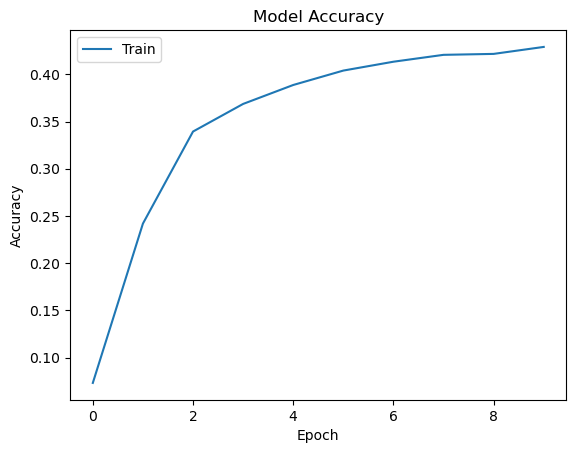

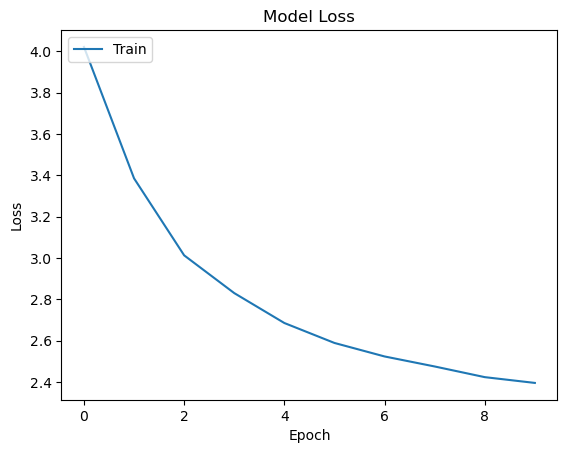

In [13]:
# Cell 7: Evaluate the Model and Plot Results
# Plot training accuracy values
plt.plot(history.history['accuracy'])
# If you have validation data, include 'val_accuracy'
# plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training loss values
plt.plot(history.history['loss'])
# If you have validation data, include 'val_loss'
# plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Save the trained model
model.save('cat_breed_classifier.h5')


4. Evaluate and Save the Model

In [15]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16  # Import VGG16 for transfer learning
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import os

# Check if GPU is available
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")


GPU available: []


In [17]:
# Define paths to data
train_data_dir = 'dog_cat_cleaned/cat/'  # Adjust path based on your directory structure
img_height, img_width = 128, 128  # Adjust dimensions as needed
batch_size = 32

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Create train generator with exception handling to skip corrupted images
def safe_image_generator(generator):
    while True:
        try:
            # Generate a batch of images
            batch = next(generator)
            yield batch
        except OSError as e:
            print(f"Skipping corrupted image due to error: {str(e)}")
            continue

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    follow_links=False,
    interpolation="nearest"
)

# Wrap train_generator with safe image generator
safe_train_generator = safe_image_generator(train_generator)


Found 10050 images belonging to 67 classes.


In [19]:
# Load the VGG16 model pre-trained on ImageNet, excluding the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers for classification
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [20]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
epochs = 20  # Increase the number of epochs for better training

history = model.fit(
    safe_train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs
)


Epoch 1/20
 59/314 ━━━━━━━━━━━━━━━━━━━━ 2:25 571ms/step - accuracy: 0.0244 - loss: 4.3699Skipping corrupted image due to error: broken data stream when reading image file
314/314 ━━━━━━━━━━━━━━━━━━━━ 178s 566ms/step - accuracy: 0.0409 - loss: 4.1493
Epoch 2/20
289/314 ━━━━━━━━━━━━━━━━━━━━ 14s 566ms/step - accuracy: 0.1176 - loss: 3.6461Skipping corrupted image due to error: broken data stream when reading image file
314/314 ━━━━━━━━━━━━━━━━━━━━ 177s 565ms/step - accuracy: 0.1184 - loss: 3.6399
Epoch 3/20
  8/314 ━━━━━━━━━━━━━━━━━━━━ 2:52 565ms/step - accuracy: 0.1319 - loss: 3.4930Skipping corrupted image due to error: broken data stream when reading image file
314/314 ━━━━━━━━━━━━━━━━━━━━ 178s 567ms/step - accuracy: 0.1478 - loss: 3.4383
Epoch 4/20
104/314 ━━━━━━━━━━━━━━━━━━━━ 1:59 568ms/step - accuracy: 0.1690 - loss: 3.2954Skipping corrupted image due to error: broken data stream when reading image file
314/314 ━━━━━━━━━━━━━━━━━━━━ 178s 567ms/step - accuracy: 0.1687 - loss: 3.3035
E

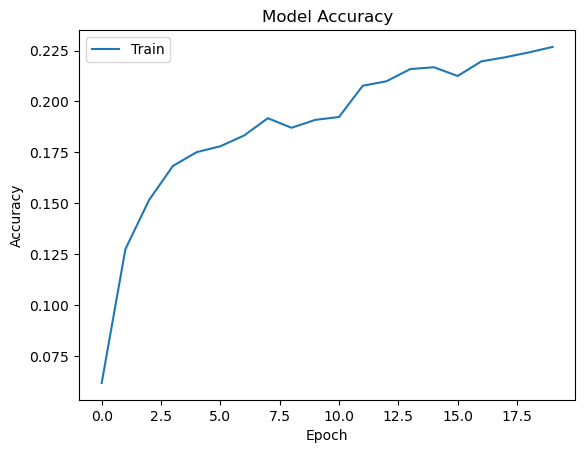

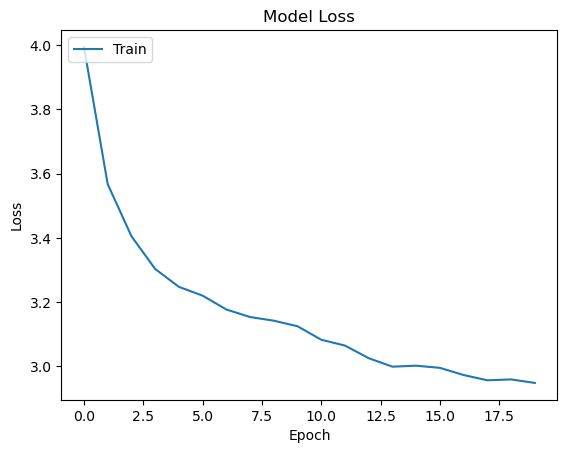

In [21]:
# Plot training accuracy values
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# Plot training loss values
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# Save the trained model to an accessible directory
output_dir = './output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

model.save(os.path.join(output_dir, 'cat_breed_classifier.h5'))
